# Import packages

In [1]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

# Define classes for parameter-container and sequence generator

In [2]:
"""
Class RateStateParams, manages data of rate-and-state friction with flash-heating effect, contains 
    Data:
        fr: Reference friction coefficient
        a: Rate-and-state parameter a
        b: Rate-and-state parameter b
        DRS: Characteristic slip distance
        Vw: Flash-heating slip rate
        fw: Flash-heating friction coefficient
"""
class RateStateParams:
    # Constructor
    def __init__(self, fr = 0.6, Vr = 1.e-6, a = 0.016, b = 0.011, DRS = 1.e-6, Vw = 1.0e6, fw = 0.2):
        self.fr = fr
        self.Vr = Vr
        self.a = a
        self.b = b
        self.DRS = DRS
        self.Vw = Vw
        self.fw = fw
        
    # Output the information of this class
    def print_info(self):
        print("-" * 20, " Rate-and-state parameters ", "-"*20)
        print('fr:       ', self.fr)
        print('a:        ', self.a)
        print('b:        ', self.b)
        print('Vr:       ', self.Vr)
        print('DRS:      ', self.DRS)
        print('Vw:       ', self.Vw)
        print('fw:       ', self.fw)
        

In [34]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        t [number of time points]: Tensor for time stamps, prescribed
        N [number of time points]: Tensor for normal stress, prescribed
        Ds [number of time points]: Tensor for slip rate, prescribed
        s [number of time points]: Tensor for slip, prescribed
        theta [number of hidden variables, number of time points]: Tensor for hidden variables, computed
        params : Class for parameters
    Method:
        __init__ : Constructor
        DthetaDt : Evolution function for hidden variables theta
        calTau : Calculate the function of shear stress Tau
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, t, N, Ds, params):
        # Load the parameters
        self.t = t
        self.N = N
        self.Ds = Ds
        self.s = torch.zeros(Ds.shape, dtype = torch.float64)
        self.s[1:] = torch.cumulative_trapezoid(Ds, x = t)
        self.params = params
        
        # Calculate theta history
        self.theta = torch.zeros(Ds.shape, dtype = torch.float64)
        
        # Compute the interpolation for slip rate Ds
        self.t_temp = torch.concat([self.t, torch.tensor([self.t[-1] + 1.0e-4])], 0)
        self.Ds_temp = torch.concat([self.Ds, torch.tensor([self.Ds[-1]])], 0)
        self.DsAtT = interp1d(self.t_temp, self.Ds_temp, kind="cubic")
        
        # Evolve theta(t)
        self.theta = self.calTheta()
        
        # Finish computing tau
        self.tau = self.calTau()
    
    # Function DthetaDt, defines DthetaDt as a function of temporally local values
    def DthetaDt(self, t, theta):
        # print('t = ', t)
        DthetaDt = (1. - torch.tensor(self.DsAtT(t)) * theta) / self.params.DRS
        return DthetaDt
    
    # Function calTau, calculates shear traction tau, suingregularized rate-and-state formulation
    def calTau(self):
        # Set aliases for rate-and-state parameters
        a = self.params.a
        b = self.params.b
        Vr = self.params.Vr
        DRS = self.params.DRS
        fr = self.params.fr
        
        tau = self.N * a * torch.asinh(
                   self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
                   )
        return tau
    
    # Calculate theta using s(t), Ds(t), theta(t) and params
    def calTheta(self, theta0 = torch.tensor(1.0)):
        theta = odeint(self.DthetaDt, theta0, self.t)
        return theta


# Demo: given $N(t)$ and $V(t)$, generate $\theta(t)$ and $\tau(t)$

In [35]:
# Set parameters
myRSParams = RateStateParams()
myRSParams.print_info()

--------------------  Rate-and-state parameters  --------------------
fr:        0.6
a:         0.016
b:         0.011
Vr:        1e-06
DRS:       1e-06
Vw:        1000000.0
fw:        0.2


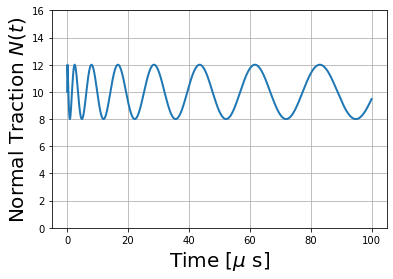

In [36]:
# Set t [s], N(t) [MPa]
t = torch.linspace(0., 100., 10000, dtype=torch.float64) * 1.0e-6
N = torch.ones(t.shape, dtype=torch.float64) * 10 + 2 * torch.sin(5 * torch.sqrt(1.e6 * t))
plt.plot(1e6 * t, N, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Normal Traction $N(t)$', fontsize=20)
plt.ylim([0, 16])
plt.grid()
plt.show()

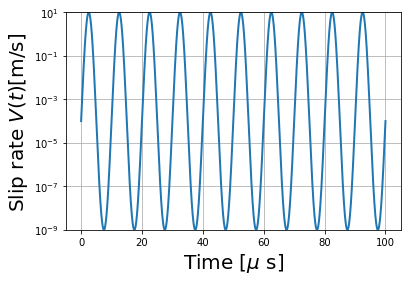

In [37]:
# Set V(t) [m/s]
T = 10. # [\mu s], minimal positive period
V = torch.pow(10., torch.ones(t.shape, dtype=torch.float64) * (-4.)  + 5. * torch.sin(2 * torch.pi / T * 1.e6 * t))
plt.semilogy(1e6 * t, V, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Slip rate $V(t) \mathrm{[m/s]}$', fontsize=20)
plt.ylim([1e-9, 10.])
plt.grid()
plt.show()

# Generate $\theta(t)$ and $\tau(t)$

In [38]:
# Call TimeSequenceGen
mySeq = TimeSequenceGen(t, N, V, myRSParams)

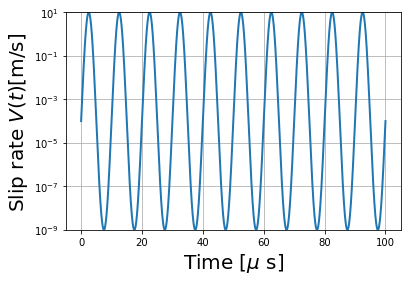

In [42]:
# Plot V(t)
plt.semilogy(1e6 * t, mySeq.Ds, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Slip rate $V(t) \mathrm{[m/s]}$', fontsize=20)
plt.ylim([1e-9, 10.])
plt.grid()
plt.show()

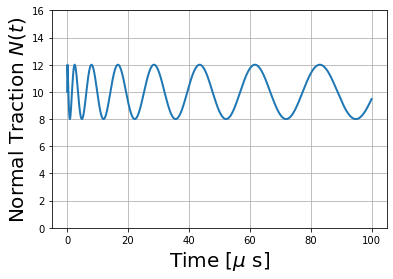

In [43]:
# Plot N(t)
plt.plot(1e6 * t, N, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Normal Traction $N(t)$', fontsize=20)
plt.ylim([0, 16])
plt.grid()
plt.show()

In [44]:
mySeq.theta

tensor([1.0000, 1.0100, 1.0200,  ..., 6.7107, 6.7206, 6.7306])

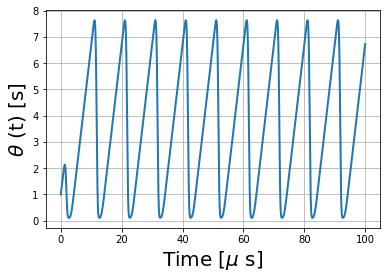

In [45]:
# Plot theta(t)
plt.plot(1e6 * mySeq.t, mySeq.theta, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('$\\theta$ (t) [s]', fontsize=20)
# plt.ylim([0, 16])
plt.grid()
plt.show()

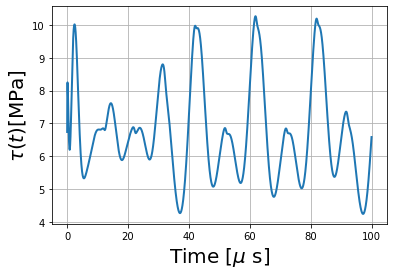

In [46]:
# Plot tau(t)
plt.plot(1e6 * mySeq.t, mySeq.tau, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('$\\tau(t) [\mathrm{MPa}]$', fontsize=20)
# plt.ylim([0, 16])
plt.grid()
plt.show()